In [126]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import pickle, gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset

In [128]:
path_to_flatland_train_data = 'data/flatland_train.data'

In [129]:
X, y = pickle.load(gzip.open(path_to_flatland_train_data, 'rb'))
# X - data of images
# y - image labels referenced as the number of corners the shape has
# Circle has 0 corners.

In [130]:
X.shape

(10000, 50, 50)

In [131]:
y.shape

(10000,)

In [132]:
np.unique(y)

array([0., 3., 4., 5., 6.])

In [133]:
y=np.where(y>0,y-2,y)
np.unique(y)

array([0., 1., 2., 3., 4.])

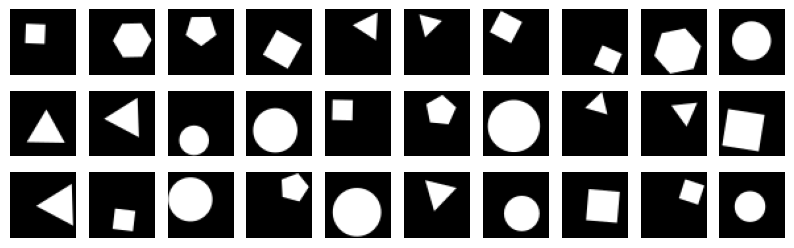

In [134]:
plt.figure(figsize=(10, 3))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')
plt.show()

In [135]:
training_images = torch.from_numpy(X).float()
training_labels = torch.from_numpy(y).long()

train_dataset = TensorDataset(training_images.unsqueeze(1), training_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [136]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [137]:
model = Network()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)

In [138]:
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = 100 * test_correct / test_total
    print(f"Epoch [{epoch + 1}/{epochs}], running_loss: {running_loss} Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/100], running_loss: 202.86143803596497 Test Accuracy: 61.45%
Epoch [2/100], running_loss: 85.96173885464668 Test Accuracy: 79.70%
Epoch [3/100], running_loss: 50.265091851353645 Test Accuracy: 89.20%
Epoch [4/100], running_loss: 31.20487155765295 Test Accuracy: 90.70%
Epoch [5/100], running_loss: 22.69981499388814 Test Accuracy: 92.90%
Epoch [6/100], running_loss: 18.555308055132627 Test Accuracy: 91.55%
Epoch [7/100], running_loss: 13.711058422923088 Test Accuracy: 92.30%
Epoch [8/100], running_loss: 11.517986150458455 Test Accuracy: 92.40%
Epoch [9/100], running_loss: 9.682466600090265 Test Accuracy: 93.90%
Epoch [10/100], running_loss: 6.234617088921368 Test Accuracy: 93.40%
Epoch [11/100], running_loss: 5.377639072947204 Test Accuracy: 94.00%
Epoch [12/100], running_loss: 3.086111026350409 Test Accuracy: 93.85%
Epoch [13/100], running_loss: 3.383361462270841 Test Accuracy: 93.40%
Epoch [14/100], running_loss: 3.6462601381354034 Test Accuracy: 93.15%
Epoch [15/100], running

In [139]:
model.eval()
incorrect_images = []
incorrect_labels = []
predicted_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

        incorrect_images.extend(images[incorrect_indices].cpu())
        incorrect_labels.extend(labels[incorrect_indices].cpu())
        predicted_labels.extend(predicted[incorrect_indices].cpu())

test_accuracy = 100 * (len(test_dataset) - len(incorrect_images)) / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Bad guesses: {len(incorrect_images)}")

Test Accuracy: 95.40%
Bad guesses: 92


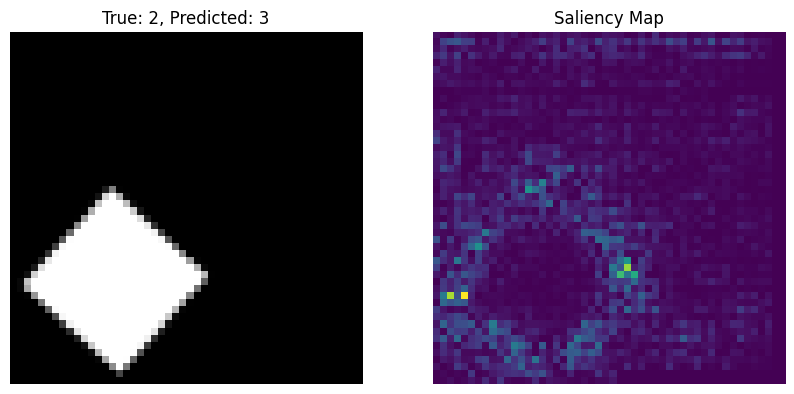

In [141]:
index = 4

image = incorrect_images[index].unsqueeze(0).to(device)
image.requires_grad_()

model.eval()
output = model(image)
_, predicted_class = torch.max(output, 1)

output[:, predicted_class].backward()
gradients = image.grad.data.abs().squeeze()
gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(incorrect_images[index].squeeze(), cmap='gray')
plt.title(f"True: {incorrect_labels[index].item()}, Predicted: {predicted_labels[index].item()}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradients.cpu())
plt.title("Saliency Map")
plt.axis('off')

plt.show()

In [144]:
torch.save(model,'model_iter1.pth')